In [106]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from scipy.optimize import curve_fit

In [107]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [108]:
s = ctl.TransferFunction.s
G = 97123.0366515921/(1.0*s**2 + 684974.722594433*s - 1324231.64800177)

G_bkp = G
G

TransferFunction(array([97123.03665159]), array([ 1.00000000e+00,  6.84974723e+05, -1.32423165e+06]))

polos:  (-684976.656+0j) (1.933+0j)
zeros: 


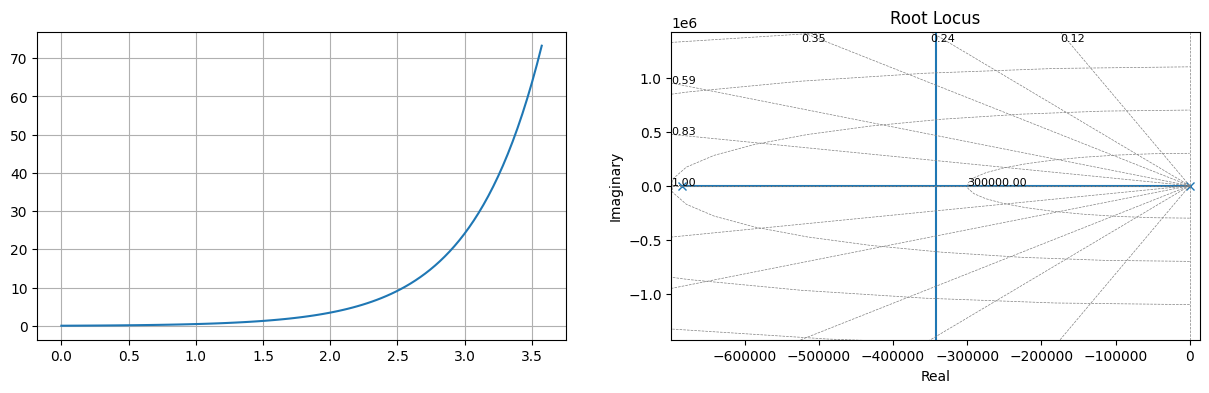

In [109]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

# INFORMAÇÕES DA RESPOSTA

In [110]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 73.26938579219375,
 'peakTime': 3.57312945777589,
 'settlingTime': None,
 'finalValue': 73.26938579219375,
 'error': 72.26938579219375}

# CONTROLADOR
- Encontrando as constantes do controlador $C(s)$

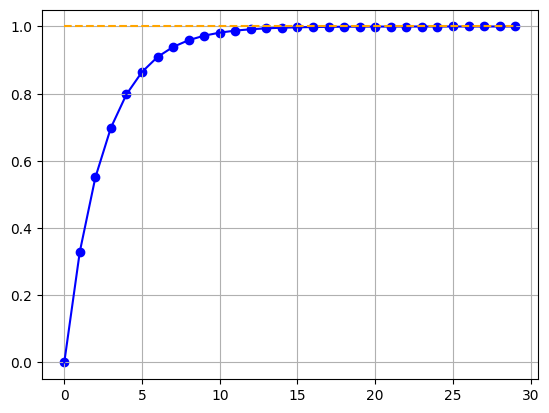

In [111]:
def getFistOrderResponse(Ts, T):
    s = ctl.TransferFunction.s
    C = 1/(0.25*Ts*s + 1)
    return ctl.step_response(C, T=T)

def getSecondOrderResponse(Ts, UP, T):
    s = ctl.TransferFunction.s
    zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
    Wn = 4/(zeta*Ts)
    C = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)
    return ctl.step_response(C, T=T)


dt = 1
Ts = 10
tData = np.arange(0, Ts*3, dt)

tData, desired = getFistOrderResponse(Ts, T=tData)
#tData, desired = secondOrderResponse(Ts, UP=0.2, T=tData)

plt.scatter(tData, desired, color='blue')
plt.plot(tData, desired, color='blue')
plt.plot(tData, [1 for i in tData], '--', color='orange')
plt.grid()

In [112]:
def C(s, a, b, c):
    s = ctl.TransferFunction.s
    G_c = a/(s**2 + b*s + c)
    
    G_feedback = ctl.feedback(G*G_c, 1)
    return ctl.step_response(G_feedback, T=tData)[1] # response

def getFunction(xDados, yDados):
    coeficientes = curve_fit(C, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [113]:
coefs = getFunction(tData, desired)  
coefs

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_lti_conversion.py:74: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  num, den = normalize(num, den)   # Strips zeros, checks arrays


[1.5484437927958325e-20, 778.5214589246647, 704.1202680437456]

In [114]:
a, b, c = coefs
C = a/(s**2 + b*s + c)
C

TransferFunction(array([1.54844379e-20]), array([  1.        , 778.52145892, 704.12026804]))

In [115]:
G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([1.50389563e-15]), array([ 1.00000000e+00,  6.85753244e+05,  5.31943993e+08, -5.48638169e+08,
       -9.32418343e+08]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

In [116]:
[np.round(val, 3) for val in list(ctl.poles(G_feedback))]

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\signal\_filter_design.py:1109: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


[(-684976.656+0j), (-777.616+0j), (1.933+0j), (-0.905+0j)]

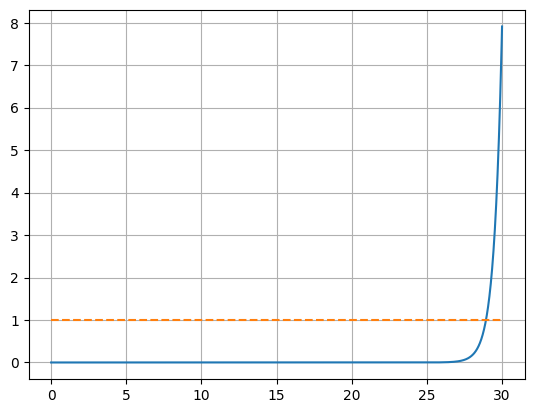

In [117]:
tData = np.linspace(0, Ts*3, 1000)

time, response = ctl.step_response(G_feedback, T=tData)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

# APLICANDO VÁRIOS STEPS

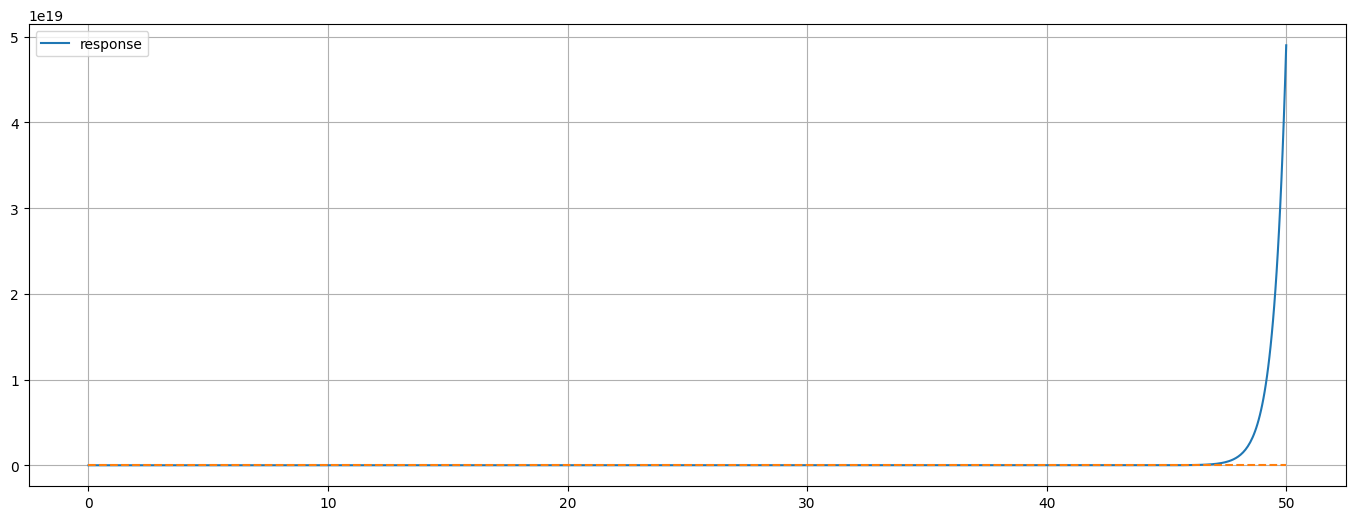

In [118]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()